# Loading packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random
import gc
import keras_cv

from os import path
from matplotlib import pyplot as plt
from tensorflow.keras import layers, losses, optimizers, metrics, callbacks, Model, Input, regularizers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=9048)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

1 Physical GPU, 1 Logical GPUs


In [3]:
SEED = 123
N_CLASS = 10
IMG_SIZE = 224
BATCH_SIZE = 512
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Loading datasets

In [5]:
train_labels_df = pd.read_csv(path.join(os.getcwd(), '..', 'train_val_test', 'train.csv')).drop(["Unnamed: 0"], axis=1)

dataset_train = image_dataset_from_directory(
    directory=path.join(os.getcwd(), '..', 'train_val_test', 'train'),
    labels=list(train_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED
)

dataset_train = dataset_train.map(lambda x, y: (x, tf.one_hot(y, N_CLASS)))

val_labels_df = pd.read_csv(path.join(os.getcwd(), '..', 'train_val_test', 'val.csv')).drop(["Unnamed: 0"], axis=1)
dataset_val = image_dataset_from_directory(
    directory=path.join(os.getcwd(), '..', 'train_val_test', 'val'),
    labels=list(val_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED
)
dataset_val = dataset_val.map(lambda x, y: (preprocess_input(x), tf.one_hot(y, N_CLASS)))

test_labels_df = pd.read_csv(path.join(os.getcwd(), '..', 'train_val_test', 'test.csv')).drop(["Unnamed: 0"], axis=1)

dataset_test = image_dataset_from_directory(
    directory=path.join(os.getcwd(), '..','train_val_test', 'test'),
    labels=list(test_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED
)
dataset_test = dataset_test.map(lambda x, y: (preprocess_input(x), tf.one_hot(y, N_CLASS)))

Found 35000 files belonging to 1 classes.
Found 5000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.


In [6]:
def get_model():
    resnet = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet", include_top=False)

    for i, layer in enumerate(resnet.layers):
        if not layer.name.startswith('conv5'):
            layer.trainable = False

    x = layers.GlobalAveragePooling2D()(resnet.output)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(2048, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(N_CLASS, activation="softmax")(x)
    model = Model(resnet.input, output)
    return model

model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Mix Up - augmentation

In [7]:
cut_mix = keras_cv.layers.preprocessing.mix_up.MixUp(seed=SEED)

def apply_cut_mix(x, y):
    samples = {"images": x, "labels": y}
    samples = cut_mix(samples, training=True)
    return samples["images"], samples["labels"]
    
dataset_train = dataset_train.map(apply_cut_mix, num_parallel_calls=AUTOTUNE)

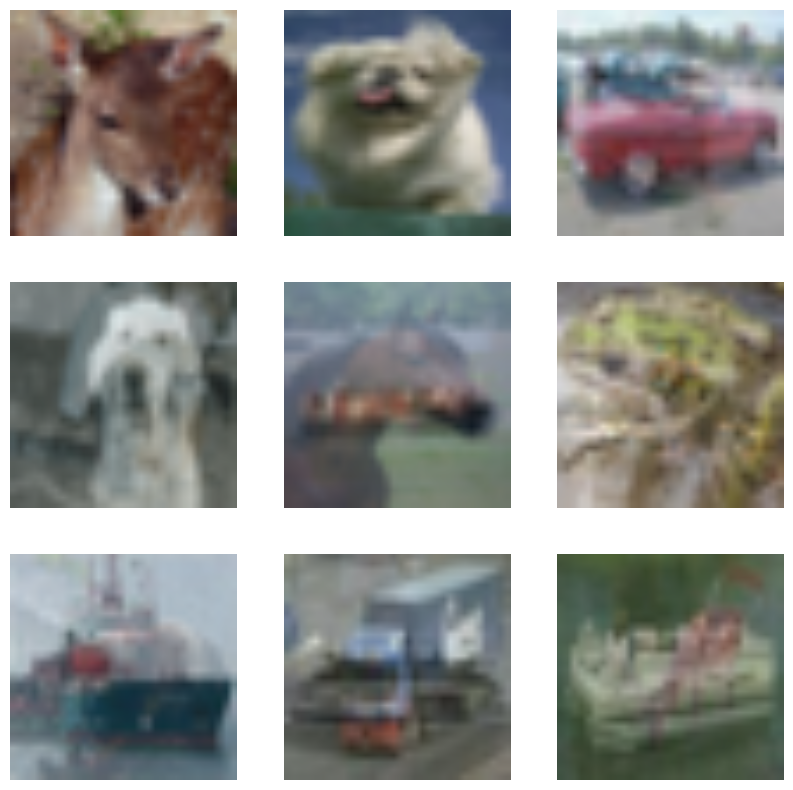

In [8]:
image_batch, label_batch = next(iter(dataset_train))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype(np.uint8))
    plt.axis("off")

In [9]:
dataset_train = dataset_train.map(lambda x, y: (preprocess_input(x), y))

# Eksperymenty

In [10]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

In [11]:
TRAINING_SEEDS = list(range(10))
results = []
for seed in TRAINING_SEEDS:
    random.seed(seed)
    np.random.seed(SEED)
    tf.random.set_seed(seed)

    model = get_model()

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.CategoricalCrossentropy(),
        metrics=[metrics.CategoricalAccuracy(), metrics.CategoricalCrossentropy()]
    )

    history = model.fit(
        dataset_train,
        epochs=200,
        batch_size=BATCH_SIZE,
        validation_data=dataset_val,
        shuffle=True,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    eval_results = model.evaluate(dataset_test, batch_size=BATCH_SIZE)

    results += [{
        'seed': seed,
        'results': dict(zip(model.metrics_names, eval_results))
    }]
    gc.collect()

results = pd.DataFrame(results)
results = pd.concat([results.drop(["results"], axis=1), results["results"].apply(pd.Series)], axis=1)
results.to_csv('mixup.csv')

Epoch 1/200
69/69 [==============================] - 72s 757ms/step - loss: 1.4859 - categorical_accuracy: 0.6929 - categorical_crossentropy: 1.4859 - val_loss: 1.1650 - val_categorical_accuracy: 0.7712 - val_categorical_crossentropy: 1.1650 - lr: 0.0010
Epoch 2/200
69/69 [==============================] - 52s 685ms/step - loss: 1.2117 - categorical_accuracy: 0.7799 - categorical_crossentropy: 1.2117 - val_loss: 8.4422 - val_categorical_accuracy: 0.7360 - val_categorical_crossentropy: 8.4422 - lr: 0.0010
Epoch 3/200
69/69 [==============================] - 52s 690ms/step - loss: 1.1390 - categorical_accuracy: 0.8049 - categorical_crossentropy: 1.1390 - val_loss: 0.8383 - val_categorical_accuracy: 0.8936 - val_categorical_crossentropy: 0.8383 - lr: 0.0010
Epoch 4/200
69/69 [==============================] - 52s 690ms/step - loss: 1.1123 - categorical_accuracy: 0.8195 - categorical_crossentropy: 1.1123 - val_loss: 0.5113 - val_categorical_accuracy: 0.9130 - val_categorical_crossentropy: 